In [1]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

### VGG19 model
First, we'd better to load the pretrained VGG19 model from ``torchvision.models``, which saves us lots of time of training the VGG19 from scratch.

VGG19 is split into two parts: 
* ``vgg19.features``, which are the convolutional and pooling layers
* ``vgg19.classifier``, which are the three linear and classifier layers

We just need to load the ``features`` portion.

In [2]:
# load features of vgg19 from torchvision models
vgg19_model = models.vgg19(pretrained = True).features

for param in vgg19_model.parameters():
    param.requires_grad_(False)

# move vgg19 model to GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19_model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

### Load and Transform Images

In [3]:
def load_image(img_path, shape=None, max_size=400):
    '''
    Load in and transform the target image defined by img_path
    '''
    
    image = Image.open(img_path)
    ### .convert('RGB')?
    
    if shape is not None:
        size = shape
    else:
        if max(image.size) > max_size:
            size = max_size
        else:
            size = max(image.size)
    
    img_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])
    
    image = img_transform(image)[:3,:,:].unsqueeze(0)
    return image

In [4]:
content = load_image('images/bridge.jpg').to(device)
style = load_image('images/style2.jpeg',shape=content.shape[-2:]).to(device)

print("content size: "+str(content.size()))
print("style size: "+str(style.size()))

content size: torch.Size([1, 3, 400, 600])
style size: torch.Size([1, 3, 400, 600])


### Restore Image
It's a function to display our images from tensor.

In [5]:
def restore_image(tensor):
    '''
    Convert a Tensor image to NumPy image for display
    '''
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0,1)
    
    return image

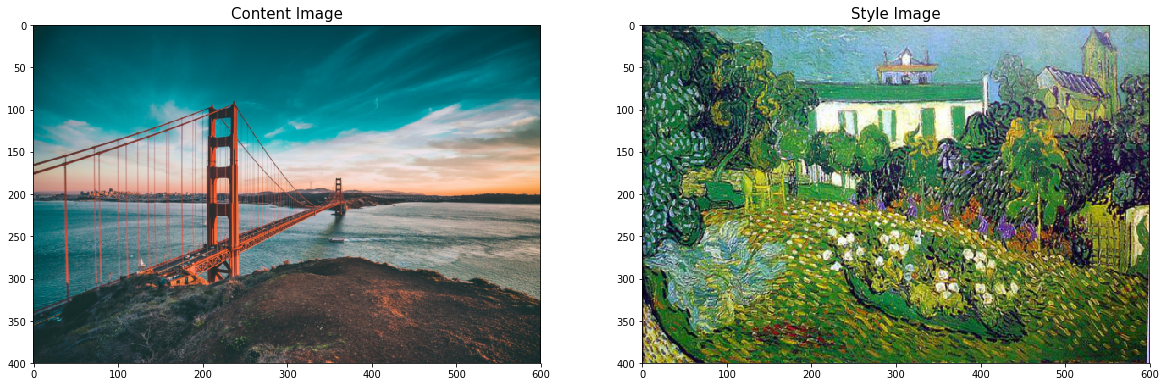

In [6]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.set_title("Content Image",fontsize = 15)
ax1.imshow(restore_image(content))
ax2.set_title("Style Image",fontsize = 15)
ax2.imshow(restore_image(style))

### Content and Style Features

In [7]:
def get_features(image, model, layers=None):
    '''
    Run an image forward through a model and get the features for 
    a set of layers.
    ''' 
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2', ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

### Gram Matrix

In [8]:
def gram_matrix(tensor):
    '''
    Calculate the Gram Matrix of a given tensor 
    '''
    
    ## get the batch_size, depth, height, and width of the Tensor
    batch_size, c, h, w = tensor.size()
    
    ## reshape it, so we're multiplying the features for each channel
    tensor = tensor.reshape(c, h * w)
    
    ## calculate the gram matrix
    gram = torch.mm(tensor, torch.transpose(tensor, 0, 1))
    
    return gram

### Preparation
Before we start our training, we need to prepare some variables.

In [ ]:
# content_features for computing content loss
content_features = get_features(content, vgg19_model)

# style_features for computing style loss
style_features = get_features(style, vgg19_model)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# initialize target image
target = content.clone().requires_grad_(True).to(device)

In [ ]:
# style_weights for different layers
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.6,
                 'conv4_1': 0.4,
                 'conv5_1': 0.2}

# weights between conten loss and style loss
content_weight = 1  # alpha
style_weight = 1e5  # beta

### Style Loss and Content Loss
Then we define a function to calculate total loss:

In [ ]:
def get_cost(target_features):
    '''
    Compute the total loss
    '''
    
    # calculate the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # calculate the tyle loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        # calculate the gram matrices of target image and style image
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        
        # calculate the style loss for one layer and add it to the style loss
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)
    
    # calculate the total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    return total_loss

### Generate Target Image!

Generating...

Iteration:  1000
Total loss:  95882.84375


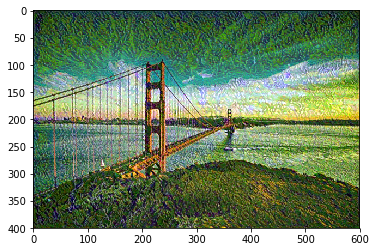

Iteration:  2000
Total loss:  29961.58203125


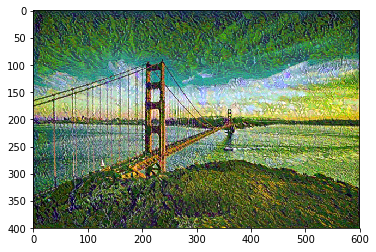

Iteration:  3000
Total loss:  14817.0537109375


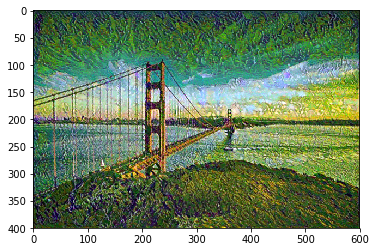

In [ ]:
# for displaying the target image, intermittently
iterations = 1000

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.01)
steps = 10000  # decide how many iterations to update your image

print('Generating...\n')
for it in range(1, steps+1):
    
    #calculate total loss 
    target_features = get_features(target, vgg19_model)
    total_loss = get_cost(target_features)
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  it % iterations == 0:
        print('Iteration: ', it)
        print('Total loss: ', total_loss.item())
        plt.imshow(restore_image(target))
        plt.show()

### Display and Store

In [ ]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(restore_image(content))
ax2.imshow(restore_image(target))

In [ ]:
# store the target image you've trained
target_image = Image.fromarray((restore_image(target) * 255).astype(np.uint8))
target_image.save('Style-Transfer-Image.jpg')